In [1]:
import os
import sys
import pickle


import openai
# import openai.ChatCompletion as ChatCompletion 
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
#summary imports
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredFileLoader


from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

#visualizations imports
import networkx as nx
import matplotlib.pyplot as plt

import importlib
from utils import *
from google_sheet import get_people_responses

from dotenv import load_dotenv

load_dotenv()


True

In [10]:
top = Topic("Backpack")
responses = get_people_responses()
solutions_str = ""
problems_str = ""
for response in responses:
    problems_str += response["problem"] + '. the reporter is ' + response['email'] + "\n"
    solutions_str += response["solution"] + '. the reporter is ' + response['email'] + "\n"

# top.classify_problems(problems_str)


In [4]:
# merged_probs = top.combain_simillar_problems(problems_str)
# print(merged_probs)
top.classify_problems(problems_str, False)


{'main_class': 'Material Wear and Tear', 'problem_name': 'Backpack Material Degradation', 'description': 'Continuous use of the backpack causes material wear and tear, leading to holes, fraying, or rips.', 'reporter': 'matan.solomo@gmail.com'}
{'main_class': 'Zipper Issues', 'problem_name': 'Zipper Failure', 'description': 'Zippers often fail due to frequent use, leading to jams, teeth breakage, or detachment.', 'reporter': 'matan.solomo@gmail.com'}
{'main_class': 'Overloading Issues', 'problem_name': 'Seam and Stitching Strain', 'description': 'Overloading the backpack or carrying heavy items can strain seams and stitching, causing them to weaken or unravel.', 'reporter': 'matan.solomo@gmail.com'}
{'main_class': 'Abrasion Issues', 'problem_name': 'Backpack Abrasions', 'description': "Continuous contact with rough surfaces leads to abrasions, scuffs, and scratches, compromising the backpack's integrity.", 'reporter': 'matan.solomo@gmail.com'}
{'main_class': 'Strap and Buckle Issues', '

In [16]:
top.classify_problems(problems_str)

go to merge
after combine: 
 Problem 1: Continuous use of the backpack causes material wear and tear, leading to holes, fraying, or rips. This is also exacerbated by continuous contact with rough surfaces which leads to abrasions, scuffs, and scratches, compromising the backpack's integrity. 

Problem 2: Zippers often fail due to frequent use, leading to jams, teeth breakage, or detachment.

Problem 3: Overloading the backpack or carrying heavy items can strain seams and stitching, causing them to weaken or unravel.

Problem 4: Straps and buckles may weaken, stretch, or break due to constant adjustments or excessive tension. This is further worsened by the constant need for adjustments and the strain of heavy loads which weaken straps and buckles, causing them to lose functionality or break.

Reporter: matan.solomo@gmail.com
{'main_class': 'Material Deterioration', 'problem_name': 'Backpack Wear and Tear', 'description': "Continuous use of the backpack causes material wear and tear, le

: 

In [15]:
# top.classify_problems(problems_str)
top.classify_solutions(solutions_str)

start classify solutions
{'main_class': 'Durability', 'sub_class': 'Material Quality', 'description': 'Use high-quality materials, reinforce stress points, and choose backpacks with reinforced stitching to prevent holes, fraying, and overloading.', 'grade': {'cost': 3, 'feasibility': 4, 'efficiency': 4, 'Scalability': 2, 'Reliability': 4}}
{'main_class': 'Durability', 'sub_class': 'Zipper Strength', 'description': 'Opt for robust zippers, avoid overpacking, and use protective covers or be mindful of the surfaces your backpack comes into contact with. This will reduce the strain on zippers and prevent damage.', 'grade': {'cost': 3, 'feasibility': 4, 'efficiency': 4, 'Scalability': 2, 'Reliability': 4}}
{'main_class': 'Functionality', 'sub_class': 'Compartment Design', 'description': 'Design backpacks with multiple compartments to allow for better organization and distribution of items, preventing uneven weight distribution.', 'grade': {'cost': 3, 'feasibility': 4, 'efficiency': 4, 'Scal

Material Quality Durability
Zipper Strength Durability
Organization Functionality
Strap and Buckle Strength Functionality


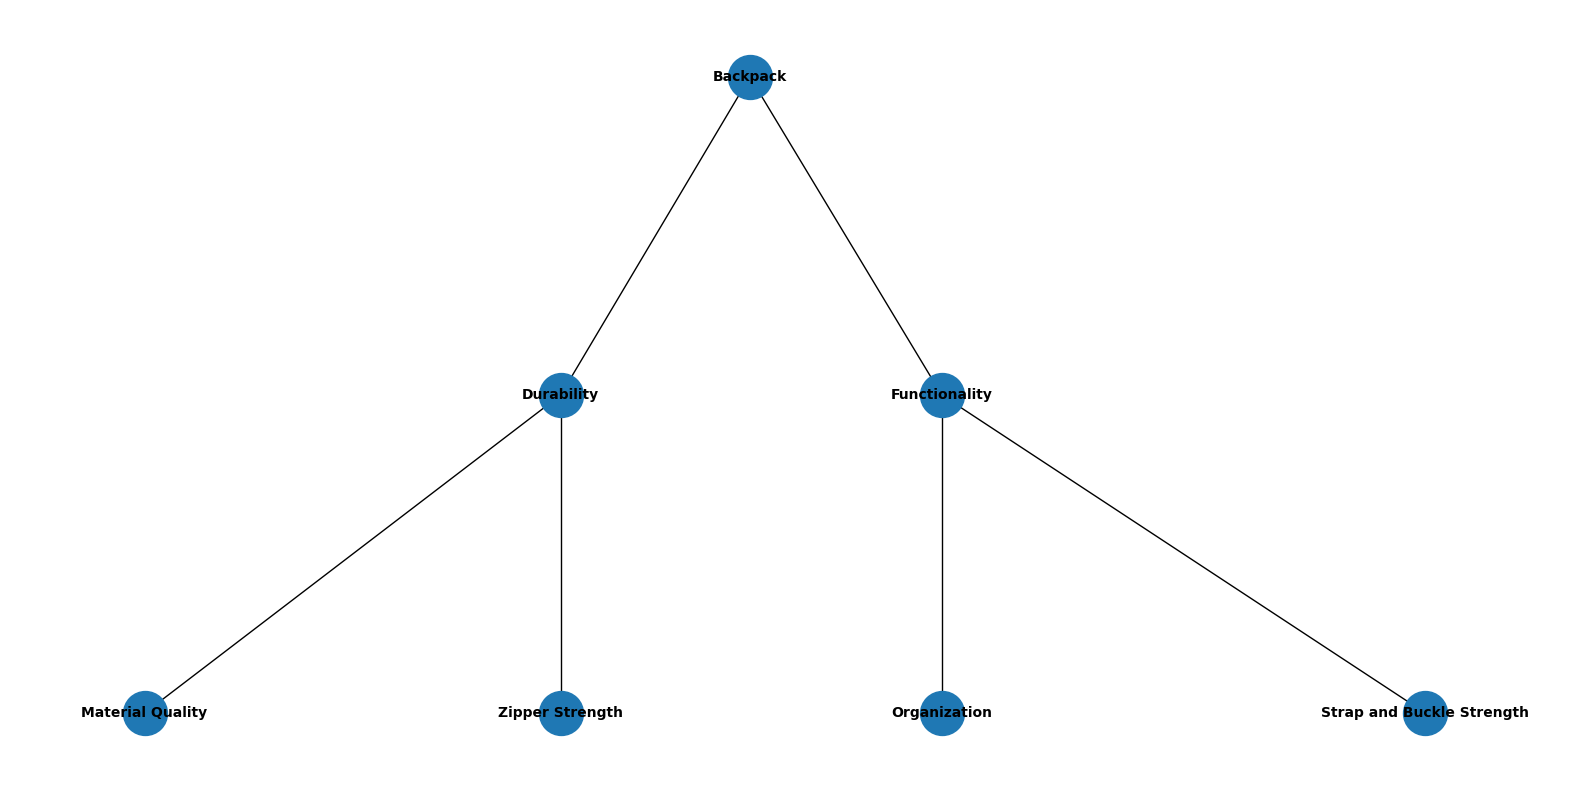

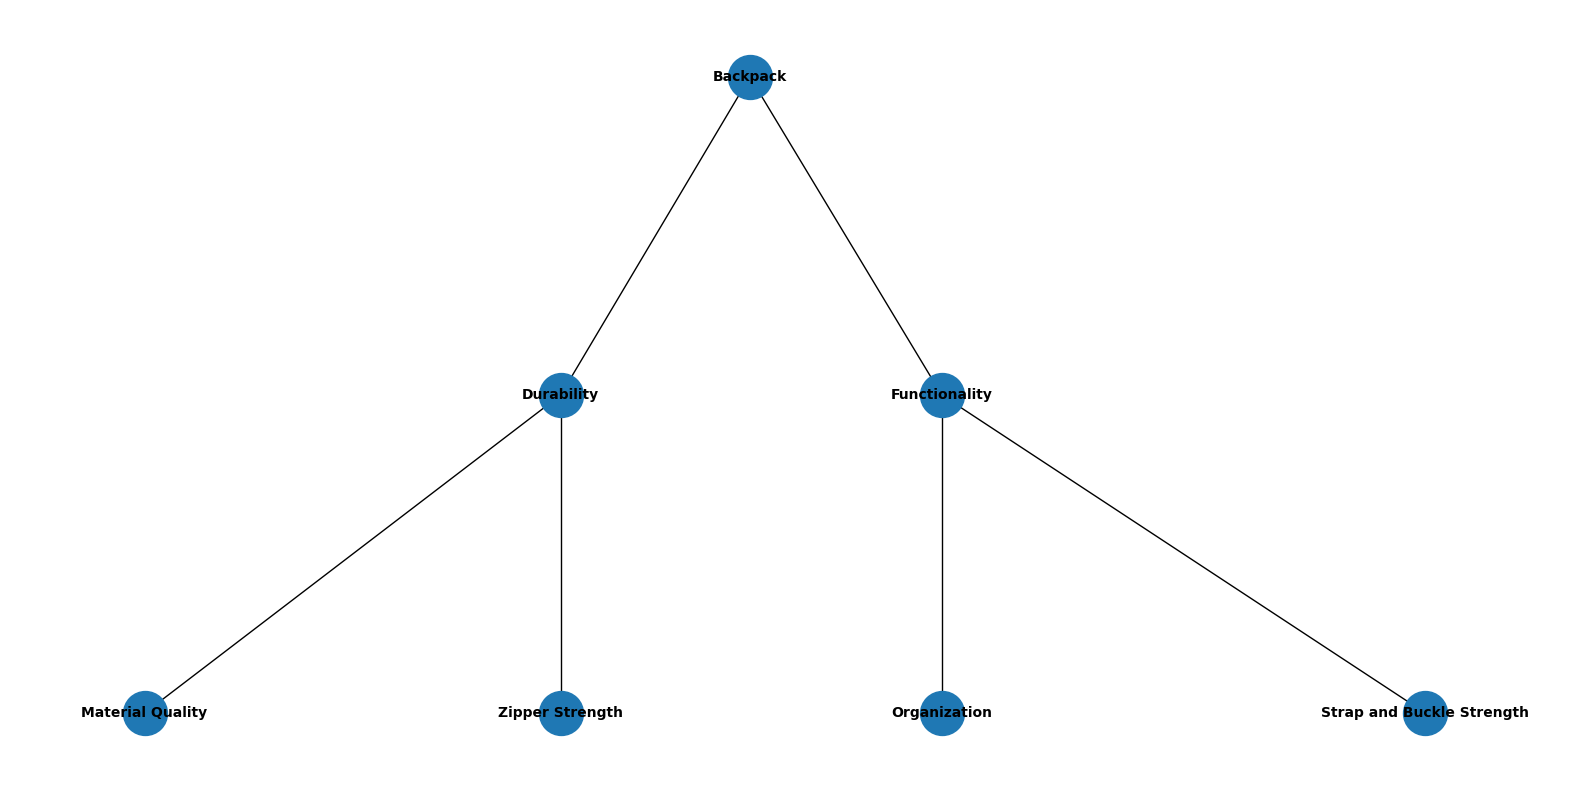

In [12]:
top.plot_hierarchy_solutions()

show plot


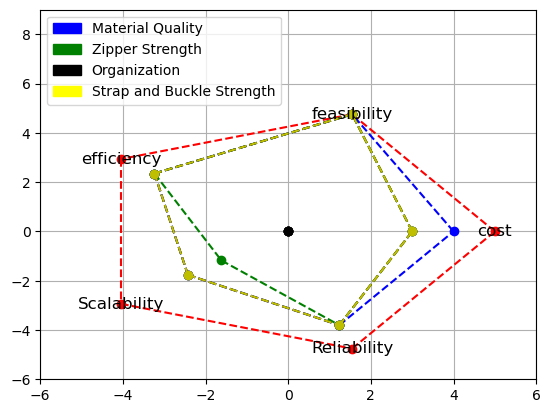

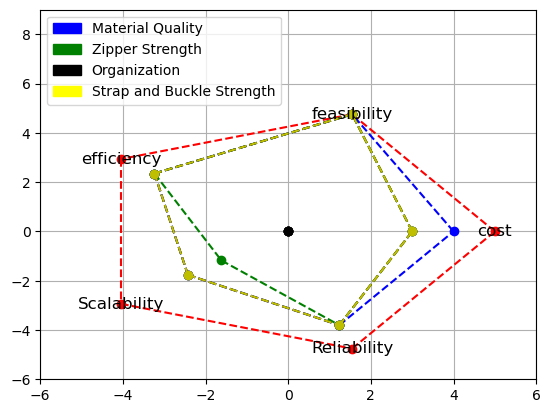

In [13]:
plot_solutions_polygons(top.solutions)

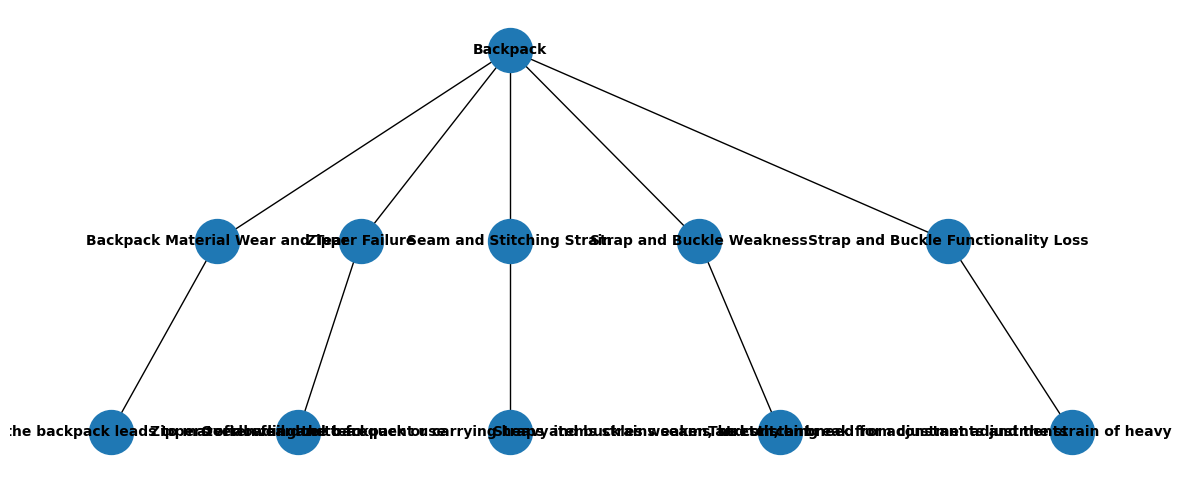

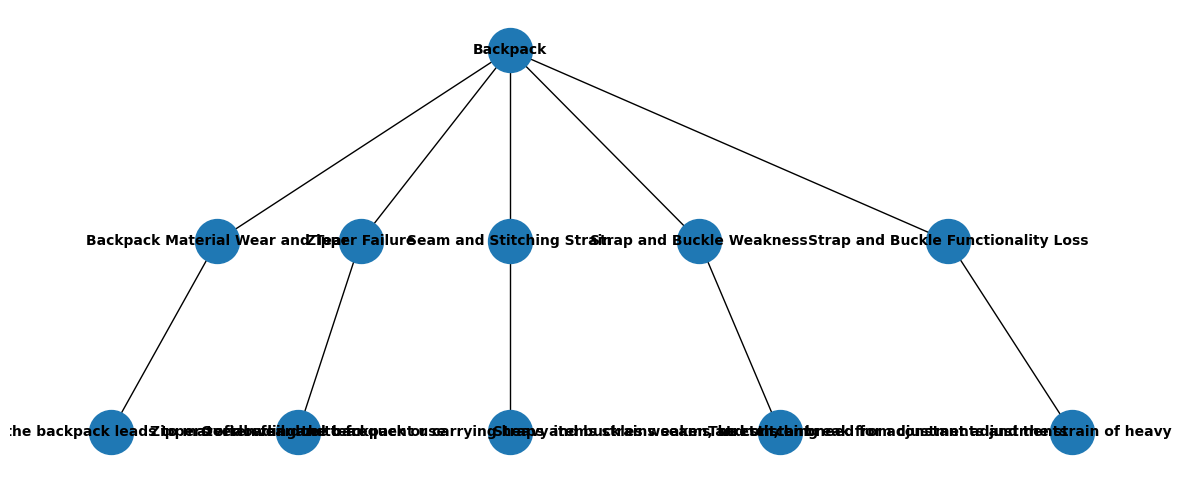

In [8]:
top.plot_hierarchy_problems()

In [9]:
merged_problems = top.combain_simillar_problems(problems_str)
print("problems after combain: ", merged_problems)

problems after combain:  Merged problems:

1. Continuous use of the backpack can cause material wear and tear, leading to holes, fraying, rips, abrasions, scuffs, and scratches, compromising the backpack's integrity.
2. Zippers often fail due to frequent use, leading to jams, teeth breakage, or detachment.
3. Overloading the backpack or carrying heavy items can strain seams, stitching, straps, and buckles, causing them to weaken, unravel, stretch, or break.
4. The constant need for adjustments and the strain of heavy loads weaken straps and buckles, leading to stretching, loss of functionality, or breakage.


In [10]:
top.classify_solutions(solutions_str)


{'main_class': 'Backpack Material', 'sub_class': 'Quality and Durability', 'description': 'Opt for backpacks made from high-quality, durable materials like Cordura nylon or ballistic nylon.', 'reporter': 'Solution 1'}
{'main_class': 'Backpack Material', 'sub_class': 'Quality and Durability', 'description': 'Choose backpacks with YKK or similarly reputable zipper brands known for durability.', 'reporter': 'Solution 2'}
{'main_class': 'Backpack Usage', 'sub_class': 'Weight Management', 'description': 'Avoid overloading the backpack or carrying heavy items to prevent strain on seams and stitching.', 'reporter': 'Solution 3'}
{'main_class': 'Backpack Protection', 'sub_class': 'Abrasion Resistance', 'description': 'Apply protective coatings or use accessories like a rain cover or protective sleeve to shield the backpack from abrasive surfaces and maintain its appearance and durability over time.', 'reporter': 'Solution 4'}
{'main_class': 'Backpack Maintenance', 'sub_class': 'Strap and Buckl

Quality and Durability Backpack Material
Quality and Durability Backpack Material
Weight Management Backpack Usage
Abrasion Resistance Backpack Protection
Strap and Buckle Replacement Backpack Maintenance
Strap and Buckle Durability Backpack Maintenance
Strap and Buckle Durability Backpack Maintenance


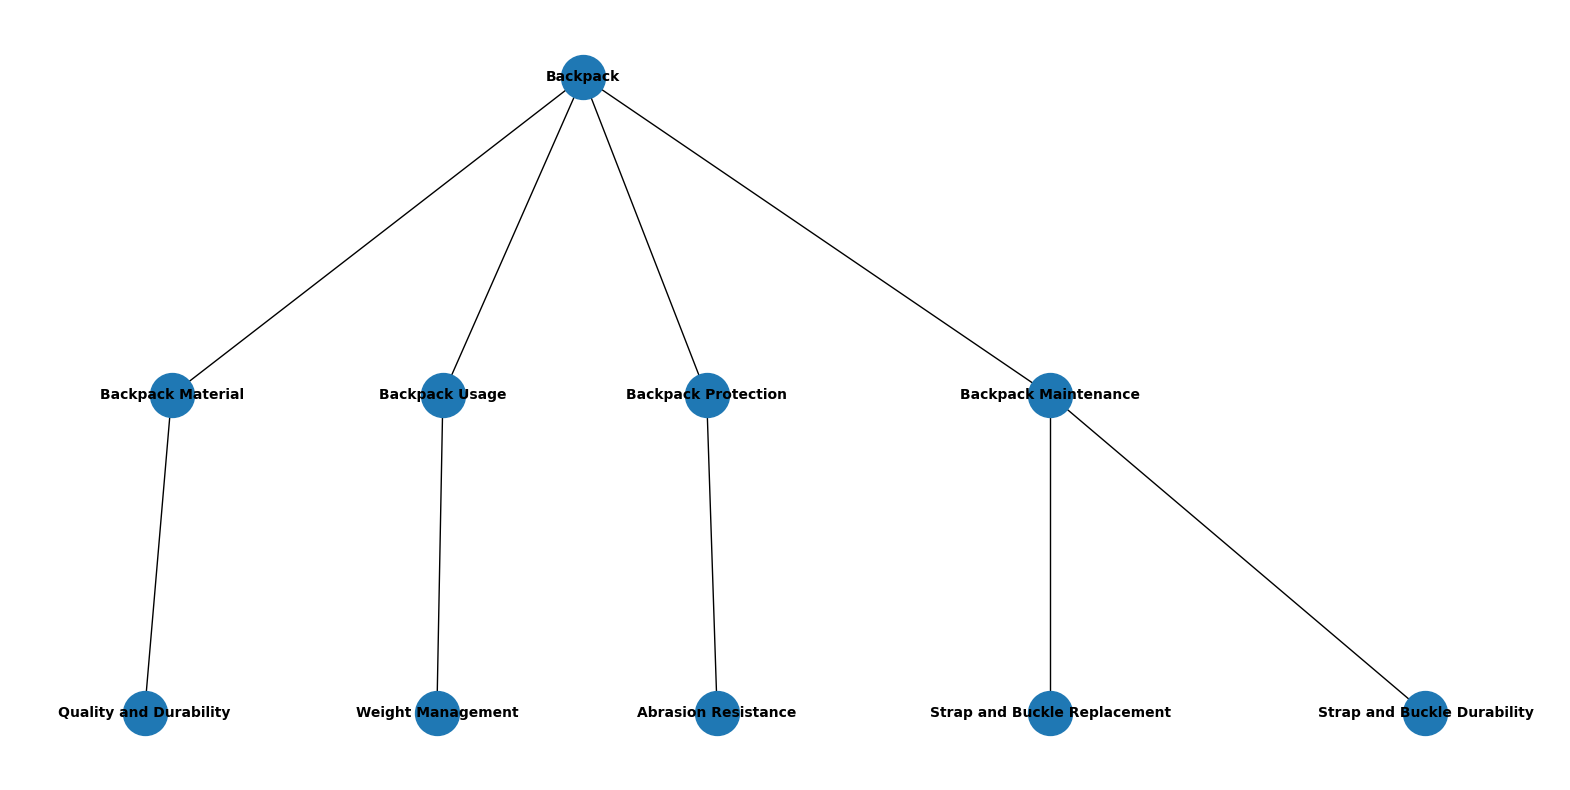

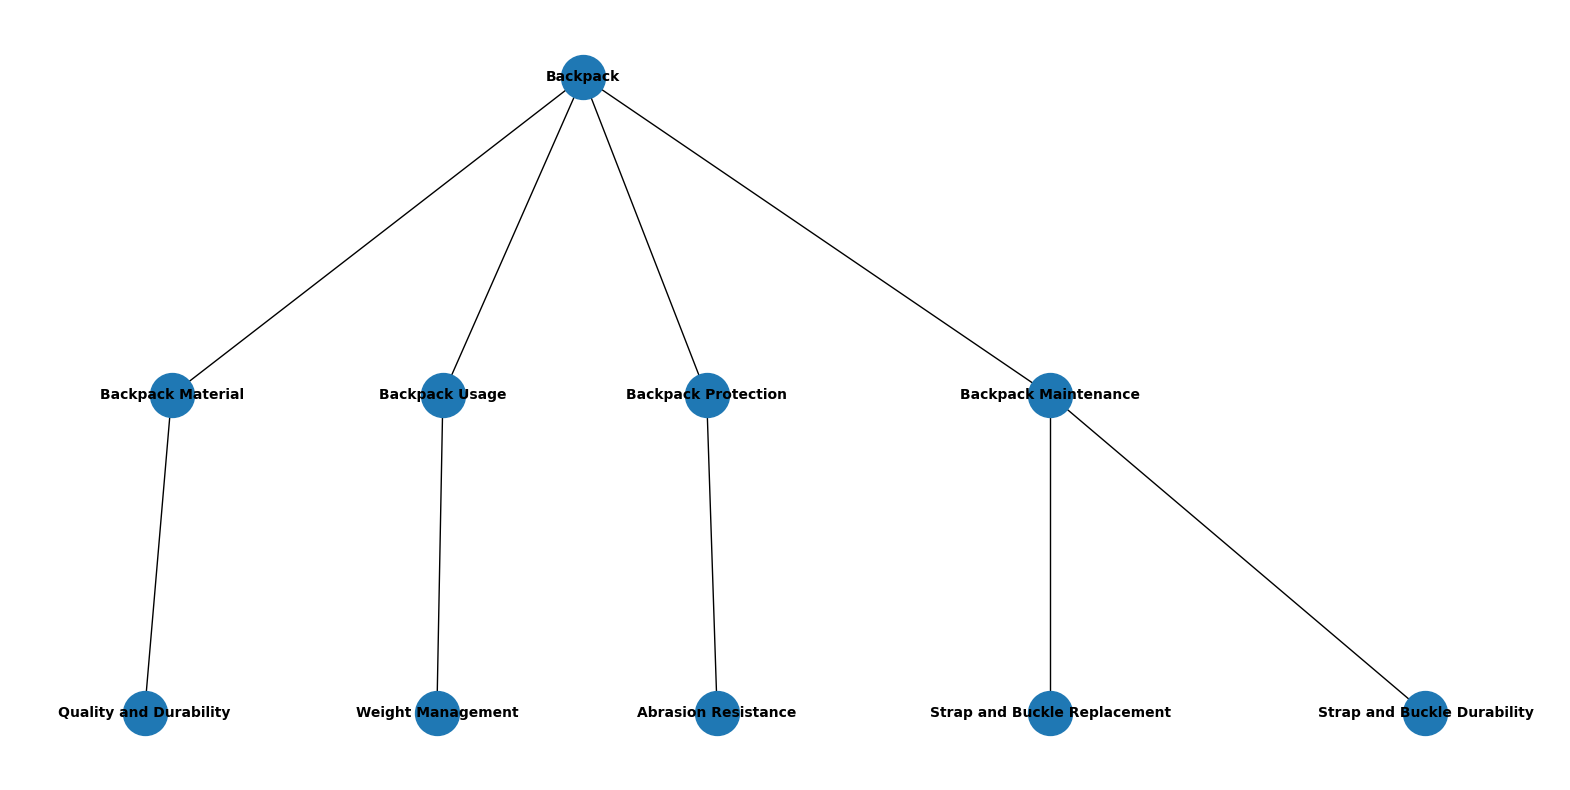

In [11]:
top.plot_hierarchy_solutions()

In [12]:
for prob in top.problems:
    print(prob.sub_class)

Continuous use of the backpack leads to material wear and tear
Zippers often fail due to frequent use
Overloading the backpack or carrying heavy items strains seams and stitching
Straps and buckles weaken, stretch, or break from constant adjustments
The constant need for adjustments and the strain of heavy loads weaken straps and buckles


Continuous use of the backpack leads to material wear and tear: Continuous use of the backpack leads to material wear and tear, including holes, fraying, or rips. Additionally, continuous contact with rough surfaces compromises the backpack's integrity, causing abrasions, scuffs, and scratches.
factors list: [{'factor_name': 'Frequency of use', 'explanation': 'The more frequently a backpack is used, the higher the chances of material wear and tear, leading to holes, fraying, or rips.'}, {'factor_name': 'Load weight', 'explanation': "Carrying heavy loads in the backpack puts additional strain on the materials, increasing the likelihood of wear and tear, as well as compromising the backpack's integrity."}, {'factor_name': 'Quality of materials', 'explanation': 'The durability and strength of the materials used in the backpack construction play a significant role in determining its resistance to wear and tear, abrasions, scuffs, and scratches.'}, {'factor_name': 'Environmental conditions'

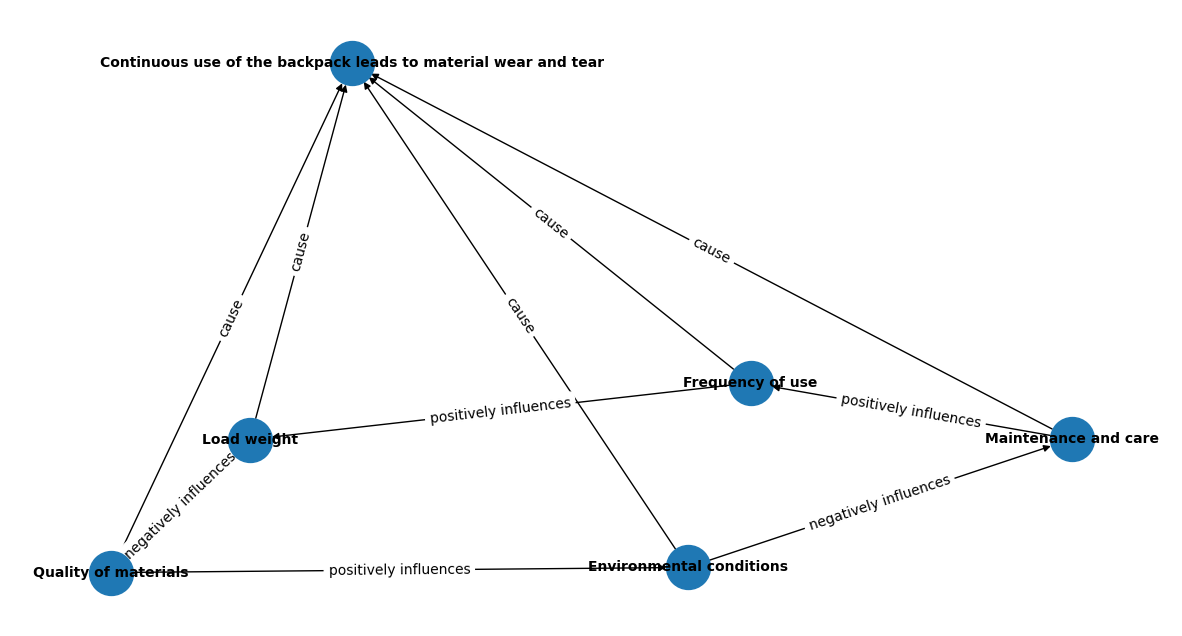

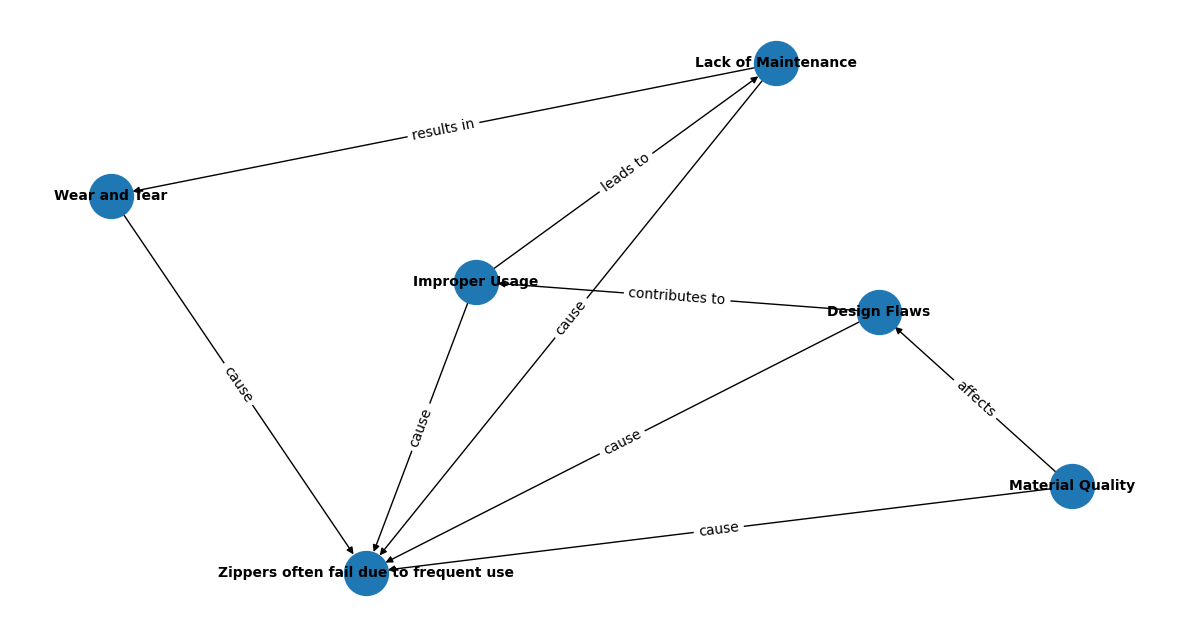

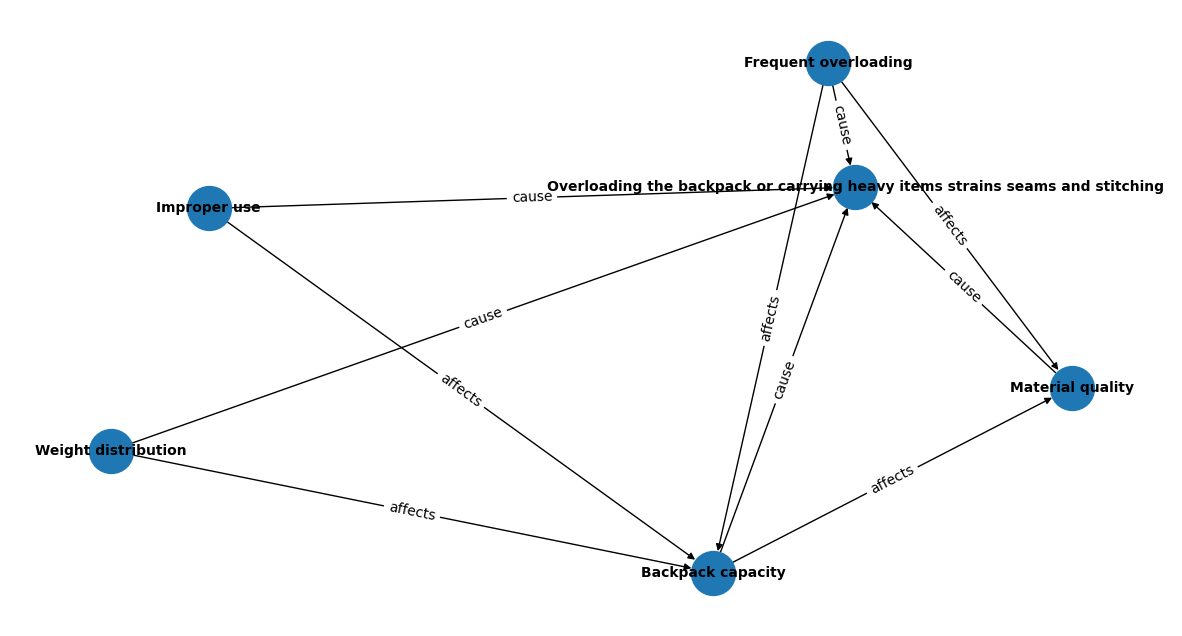

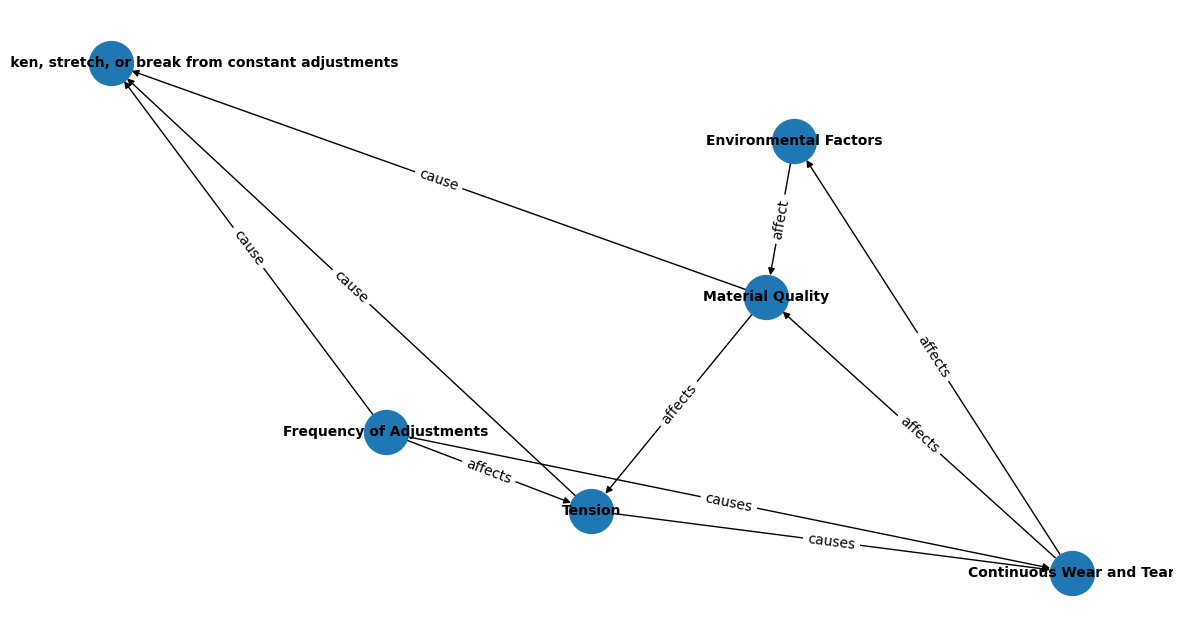

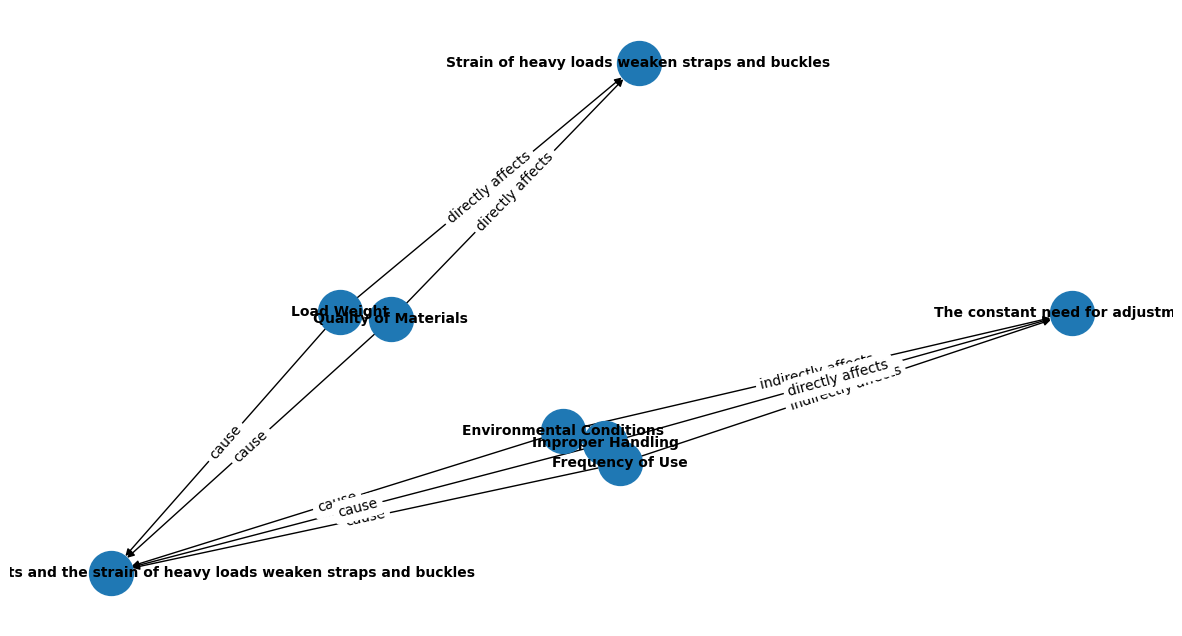

In [13]:
for prob in top.problems:
    print(f"{prob.sub_class}: {prob.description}")
    prob.create_factors()
    print(prob.factors)
    prob.build_knowledge_graph()

In [14]:
for i in range(len(top.problems)):
    top.create_challenge(i)

TypeError: 'int' object is not iterable

# from pickle

In [11]:
from utils import *
from utils import Topic


In [2]:
with open("demo.pickle", "rb") as file:
    top = pickle.load(file)
responses = get_people_responses()
solutions_str = ""
problems_str = ""
for response in responses:
    problems_str += response["problem"] + '. the reporter is ' + response['email'] + "\n"
    solutions_str += response["solution"] + '. the reporter is ' + response['email'] + "\n"

top.classify_problems(problems_str)


go to merge
after combine:  Merged problems:
1. Continuous use of the backpack causes material wear and tear, leading to holes, fraying, rips, and compromising the backpack's integrity.
2. Zippers often fail due to frequent use, leading to jams, teeth breakage, or detachment.
3. Overloading the backpack or carrying heavy items can strain seams, stitching, and weaken or unravel them.
4. Continuous contact with rough surfaces leads to abrasions, scuffs, scratches, and compromising the backpack's integrity.
5. Straps and buckles may weaken, stretch, or break due to constant adjustments, excessive tension, wear and tear, or strain.
6. The constant need for adjustments and the strain of heavy loads weaken straps and buckles, causing them to lose functionality or break.


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


{'class': 'Backpack Wear and Tear', 'problem_name': 'Material Wear and Tear', 'description': "Continuous use of the backpack causes material wear and tear, leading to holes, fraying, rips, and compromising the backpack's integrity.", 'reporter': 'User'}
{'class': 'Backpack Wear and Tear', 'problem_name': 'Zippers Failure', 'description': 'Zippers often fail due to frequent use, leading to jams, teeth breakage, or detachment.', 'reporter': 'User'}
{'class': 'Backpack Strain', 'problem_name': 'Seam and Stitching Weakness', 'description': 'Overloading the backpack or carrying heavy items can strain seams, stitching, and weaken or unravel them.', 'reporter': 'User'}
{'class': 'Backpack Wear and Tear', 'problem_name': 'Contact with Rough Surfaces', 'description': "Continuous contact with rough surfaces leads to abrasions, scuffs, scratches, and compromising the backpack's integrity.", 'reporter': 'User'}
{'class': 'Backpack Wear and Tear', 'problem_name': 'Strap and Buckle Weakening', 'desc

In [4]:
file_name = "demo1.pickle"
with open(file_name, "wb") as file: 
    pickle.dump(top, file)

laod_top = None
with open(file_name, "rb") as file:
    laod_top = pickle.load(file)

print(laod_top.problems)

[<utils.Problem object at 0x0000020AE93C8A00>, <utils.Problem object at 0x0000020AE93C83A0>, <utils.Problem object at 0x0000020AE93C8940>, <utils.Problem object at 0x0000020AE93C8AC0>, <utils.Problem object at 0x0000020AE93C8700>, <utils.Problem object at 0x0000020AE93C8220>]


In [16]:
top = Topic("Backpack")
responses = get_people_responses()
solutions_str = ""
problems_str = ""
for response in responses[:3]:
    problems_str += response["problem"] + '. the reporter is ' + response['email'] + "\n"
    solutions_str += response["solution"] + '. the reporter is ' + response['email'] + "\n"

# create problems and solutions from the people responses
top.classify_problems(problems_str)
# top.classify_solutions(solutions_str)

# for each problem create factors and triplets for the knowledge graph
# for prob in top.problems[:2]:
#     prob.create_factors()


go to merge
after combine:  Based on the sentences provided, here are the merged problems with the backpack:

1. Continuous use of the backpack leads to material wear and tear, resulting in holes, fraying, or rips.
2. Zippers often fail due to frequent use, resulting in jams, teeth breakage, or detachment.
3. Overloading the backpack or carrying heavy items strains seams and stitching, causing them to weaken or unravel.
{'class': 'Material Wear and Tear', 'problem_name': 'Holes', 'description': 'Continuous use of the backpack leads to material wear and tear, resulting in holes.', 'reporter': 'User'}
{'class': 'Material Wear and Tear', 'problem_name': 'Fraying', 'description': 'Continuous use of the backpack leads to material wear and tear, resulting in fraying.', 'reporter': 'User'}
{'class': 'Material Wear and Tear', 'problem_name': 'Rips', 'description': 'Continuous use of the backpack leads to material wear and tear, resulting in rips.', 'reporter': 'User'}
{'class': 'Zippers Failur

In [17]:
# save to pickle file
file_name = "demo1.pickle"
with open(file_name, "wb") as file:
    pickle.dump(top, file)

In [18]:
file_name = "demo1.pickle"
with open(file_name, "rb") as file:
    copy_top = pickle.load(file)

    print(copy_top.problems)

[]


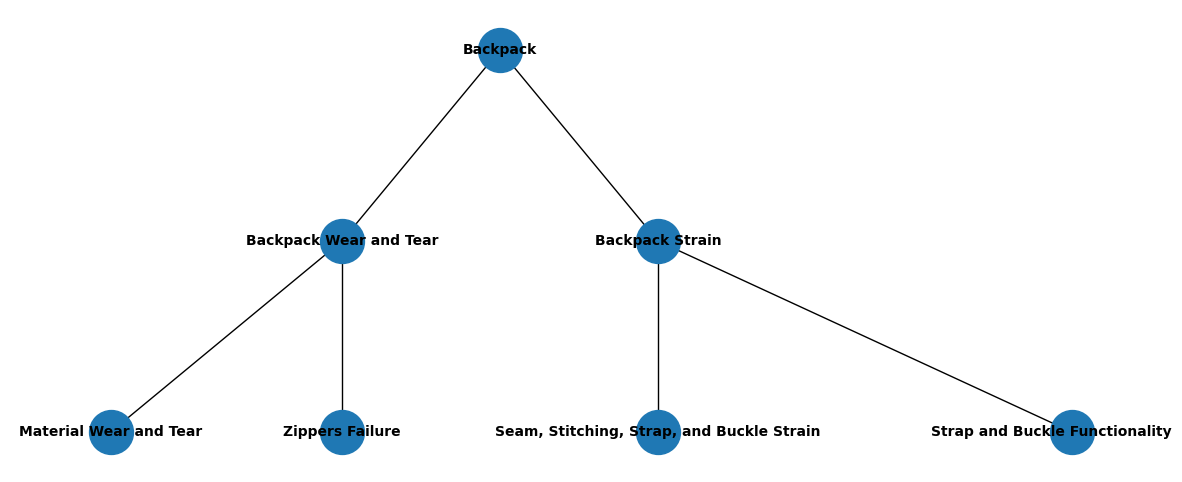

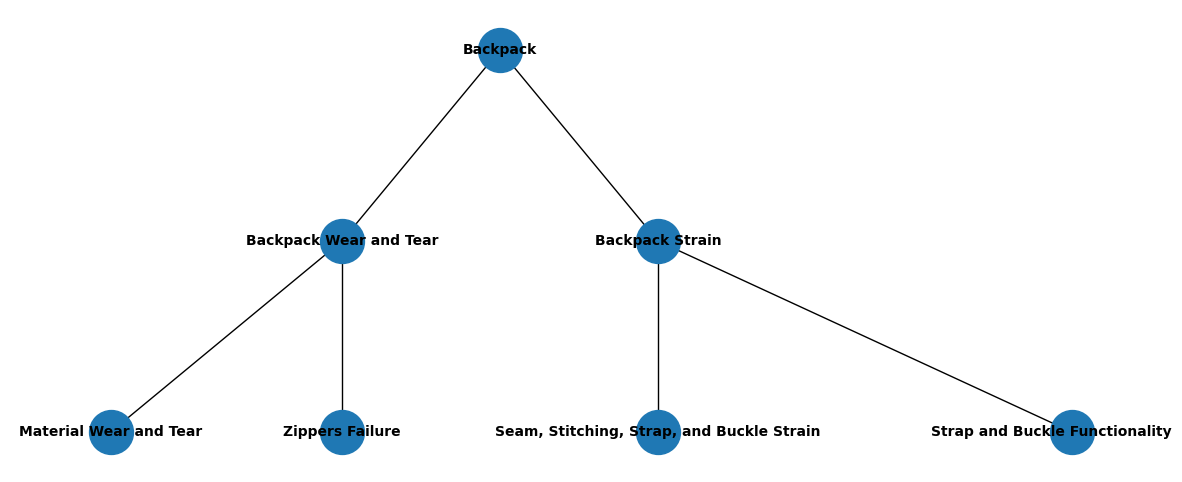

In [7]:
with open("demo.pickle", "rb") as file:
    top2 = pickle.load(file)

top2.plot_hierarchy_problems()

In [10]:
# plot_solutions_polygons(top2.solutions)
top2.solutions[0].grade

'evaluate dict'